In [13]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.io 
from torch.optim.lr_scheduler import StepLR


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

cuda


# Data

In [14]:
train_dir = '/kaggle/input/aiomodule5fer2013/train'
test_dir = '/kaggle/input/aiomodule5fer2013/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

print(classes)
print(label2idx)
print(idx2label)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
{'surprise': 0, 'fear': 1, 'angry': 2, 'neutral': 3, 'sad': 4, 'disgust': 5, 'happy': 6}
{0: 'surprise', 1: 'fear', 2: 'angry', 3: 'neutral', 4: 'sad', 5: 'disgust', 6: 'happy'}


Image height: 128
Image width: 128


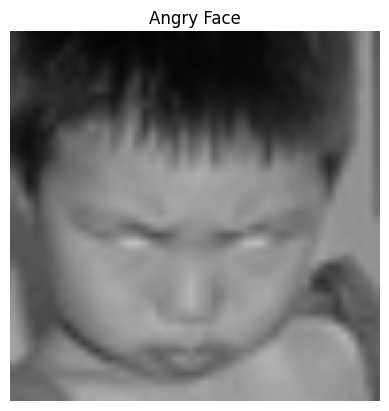

In [15]:
test_img_path = '/kaggle/input/aiomodule5fer2013/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)

img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

# Resize if needed
img = cv2.resize(img, (128, 128))

# Plot the image
plt.imshow(img)
plt.title('Angry Face')
plt.axis('off')  # Hide axis ticks
plt.show()

# Dataset

In [16]:
img_dir = "/kaggle/input/aiomodule5fer2013/train"
cls = "angry"
class_folder_path = os.path.join(img_dir, cls)
img_name_list = os.listdir(class_folder_path)
print(class_folder_path)
print(img_name_list[:5])

/kaggle/input/aiomodule5fer2013/train/angry
['Training_52322132.jpg', 'Training_93516694.jpg', 'Training_59490301.jpg', 'Training_20556787.jpg', 'Training_98419709.jpg']


In [17]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, img_heigh, img_width, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = transforms.Resize((img_heigh, img_width))
        self.norm = norm
        self.split = split 
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx

        # Read Data
        self.img_paths, self.img_labels = self.read_img_files()

        # Split Data
        self.img_paths, self.img_labels = self.split_data()

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            class_folder_path = os.path.join(self.img_dir, cls)
            
            for img_name in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_name)
                img_paths.append(img_path)
                img_labels.append(cls)
        return img_paths, img_labels

    def split_data(self):
        if self.split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = self.train_ratio,
                random_state = random_state,
                stratify = self.img_labels
            )
            if self.split == "train":
                self.img_paths, self.img_labels = zip(*train_data)
            elif self.split == "val":
                self.img_paths, self.img_labels = zip(*val_data)
        return self.img_paths, self.img_labels

    def __len__(self):
        return len(self.img_paths)
        
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = torchvision.io.read_image(img_path)
        img = self.resize(img)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5)-1
        return img, label

In [18]:
train_dataset = ImageDataset(
    img_dir = train_dir, 
    img_heigh = 128, img_width = 128,
    norm = True,
    label2idx = label2idx,
    split = 'train'
)

val_dataset = ImageDataset(
    img_dir = train_dir, 
    img_heigh = 128, img_width = 128,
    norm = True,
    label2idx = label2idx,
    split = 'val'
)

test_dataset = ImageDataset(
    img_dir = test_dir, 
    img_heigh = 128, img_width = 128,
    norm = True,
    label2idx = label2idx,
    split = 'test'
)

In [19]:
print(len(train_dataset))
print(train_dataset[10][0].shape, idx2label[train_dataset[10][1]])

22967
torch.Size([1, 128, 128]) sad


# Data Loader

In [20]:
batch_size = 2048
train_loader = DataLoader(train_dataset, 
                              batch_size = batch_size,
                             shuffle = True)
val_loader = DataLoader(val_dataset, 
                            batch_size = batch_size,
                            shuffle = True)
test_loader = DataLoader(test_dataset, 
                             batch_size = batch_size,
                             shuffle = True)

In [21]:
Sample_X = next(iter(train_loader))[0]
Sample_y = next(iter(train_loader))[1]
Sample_X.shape, Sample_y.shape

(torch.Size([2048, 1, 128, 128]), torch.Size([2048]))

# Build Model

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, output_size):
        super().__init__()

        self.flatten = nn.Flatten()
        layers = [
            nn.Linear(input_size, hidden_size*(hidden_layer)),
            nn.LeakyReLU(0.1)
        ]

        for i in range(hidden_layer-1):
            layers.append(nn.Linear(hidden_size*(hidden_layer-i), hidden_size*(hidden_layer-i-1)))
            layers.append(nn.LeakyReLU(0.1))

        layers.append(nn.Linear(hidden_size, output_size))
        
        self.classifier = nn.Sequential(*layers)

    def forward(self,X):
        X = self.flatten(X)
        z = self.classifier(X)
        return z

In [23]:
model = NeuralNetwork(
    input_size = 128*128,
    hidden_size = 256,
    hidden_layer = 4,
    output_size = len(classes)
)
print(model)
model(Sample_X).shape

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=1024, out_features=768, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=768, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=256, out_features=7, bias=True)
  )
)


torch.Size([2048, 7])

# Training Session

In [24]:
input_size = 128*128
hidden_size = 256
hidden_layer = 3
output_size = len(classes)

model = NeuralNetwork(
    input_size = input_size,
    hidden_size = hidden_size,
    hidden_layer = hidden_layer,
    output_size = output_size
)

epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# StepLR scheduler: decay LR by gamma every step_size epochs
scheduler = StepLR(optimizer, step_size=10, gamma=1/3)


def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [25]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0
best_model_weights = None

model.to(device)
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    
    model.train()
    for X_samples, y_samples in train_loader:
        # To GPU
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        # Remove accumulated gradient
        optimizer.zero_grad()

        # Forward
        outputs = model(X_samples)
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

        # Compute Loss
        loss = criterion(outputs, y_samples)
        train_loss += loss.item()

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()

    # Average Loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Average Accuracy
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            # To Gpu
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            # Forward
            outputs = model(X_samples)
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

            # Compute Loss
            val_loss += criterion(outputs, y_samples).item()
            
    # Average Loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Average Accuracy
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_weights = model.state_dict()

    # 🔁 Step the scheduler
    scheduler.step()

    # 📉 Show current LR and stats
    current_lr = scheduler.get_last_lr()[0]
    print(f'\nEPOCH {epoch + 1}: '
          f'Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, '
          f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, '
          f'LR: {current_lr:.5f}')


EPOCH 1: Train Loss: 48.114, Val Loss: 9.092, Train Acc: 0.179, Val Acc: 0.202, LR: 0.01000

EPOCH 2: Train Loss: 12.477, Val Loss: 13.455, Train Acc: 0.183, Val Acc: 0.180, LR: 0.01000

EPOCH 3: Train Loss: 12.470, Val Loss: 10.012, Train Acc: 0.196, Val Acc: 0.142, LR: 0.01000

EPOCH 4: Train Loss: 8.113, Val Loss: 8.146, Train Acc: 0.176, Val Acc: 0.182, LR: 0.01000

EPOCH 5: Train Loss: 9.489, Val Loss: 20.770, Train Acc: 0.198, Val Acc: 0.140, LR: 0.01000

EPOCH 6: Train Loss: 23.371, Val Loss: 6.223, Train Acc: 0.193, Val Acc: 0.144, LR: 0.01000

EPOCH 7: Train Loss: 5.289, Val Loss: 4.028, Train Acc: 0.195, Val Acc: 0.184, LR: 0.01000

EPOCH 8: Train Loss: 2.801, Val Loss: 2.072, Train Acc: 0.228, Val Acc: 0.268, LR: 0.01000

EPOCH 9: Train Loss: 1.897, Val Loss: 1.805, Train Acc: 0.266, Val Acc: 0.279, LR: 0.01000

EPOCH 10: Train Loss: 1.750, Val Loss: 1.730, Train Acc: 0.308, Val Acc: 0.316, LR: 0.00333

EPOCH 11: Train Loss: 1.704, Val Loss: 1.712, Train Acc: 0.331, Val Acc

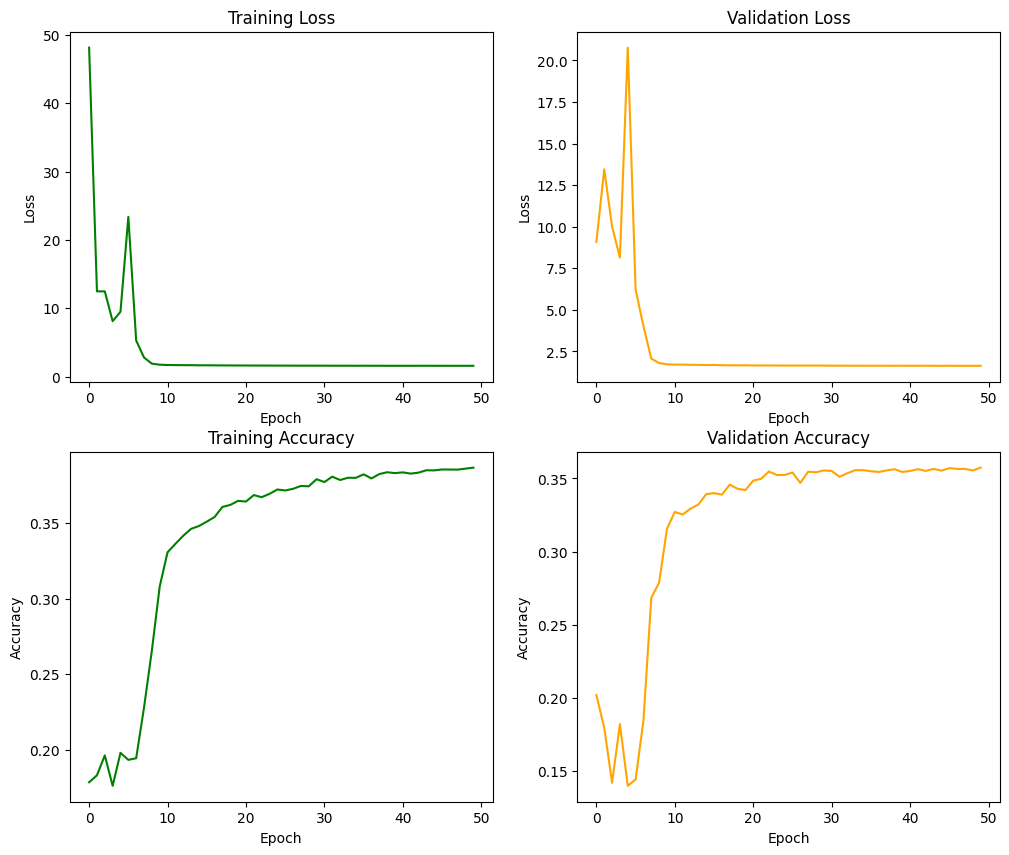

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Evaluation

In [27]:
# Load the best model weights
model.load_state_dict(best_model_weights)
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=768, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [28]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.3573667711598746
